In [1]:
ls

Customer Lifetime Value.ipynb  LICENSE
HW1 clv_transactions.csv       README.md


In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

/Users/sparshtekriwal/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Background: Customer Lifetime Value
In marketing, customer lifetime value (CLV or often CLTV), lifetime customer value (LCV), or life-time value (LTV) is a prediction of the net profit attributed to the entire future relationship with a customer. Customer lifetime value can also be defined as the dollar value of a customer relationship, based on the present value of the projected future cash flows from the customer relationship. Customer lifetime value is an important concept in that it encourages firms to shift their focus from quarterly profits to the long-term health of their customer relationships. Customer lifetime value is an important number because it represents an upper limit on spending to acquire new customers. For this reason it is an important element in calculating payback of advertising spent in marketing mix modeling.

In [3]:
df = pd.read_csv("HW1 clv_transactions.csv", date_parser=True)

In [4]:
df.head()

,TransactionID,TransactionDate,CustomerID,Amount
0,1,9/4/2012,1,20.26
1,2,5/15/2012,2,10.87
2,3,5/23/2014,2,2.21
3,4,10/24/2014,2,10.48
4,5,10/13/2012,2,3.94


## Step 1 - About the Dataset
The dataset available is in CSV format and contains 4,200 transactions records. Each row in the dataset represent a single transaction. There are four columns in the dataset. 
- The TransactionID is a unique identifier of individual transactions. 
- The TransactionDate is the date of the transaction. 
- The CustomerID is the identifier of the customer who made the transaction. 
- And the Amount is the recorded amount of transaction in US dollars.


In [5]:
df.isna().sum() # 1. There are no missing values in the dataset

TransactionID      0
TransactionDate    0
CustomerID         0
Amount             0
dtype: int64

In [6]:
print("Min. Transaction Date: {}".format(df.TransactionDate.apply(lambda x:datetime.strptime(x, '%m/%d/%Y')).min())) # 2. Min Transaction Date
print("Max. Transaction Date: {}".format(df.TransactionDate.apply(lambda x:datetime.strptime(x, '%m/%d/%Y')).max())) # 2. Max Transaction Date

Min. Transaction Date: 2010-01-04 00:00:00
Max. Transaction Date: 2015-12-31 00:00:00


In [7]:
print("Count of unique customers: {}".format(len(set(df.CustomerID)))) # 3. Count of unique customers

Count of unique customers: 1000


In [8]:
print("*Descriptive Stats*:\nMin: {}, Max: {}, Var: {:.2f}, Std: {:.2f}".format(df.Amount.min(),df.Amount.max(), df.Amount.var(), df.Amount.std()))


*Descriptive Stats*:
Min: -1.0, Max: 2033.0, Var: 1499.54, Std: 38.72


In [9]:
df["Trx_Year"] = df.TransactionDate.apply(lambda x:datetime.strptime(x, '%m/%d/%Y').year)

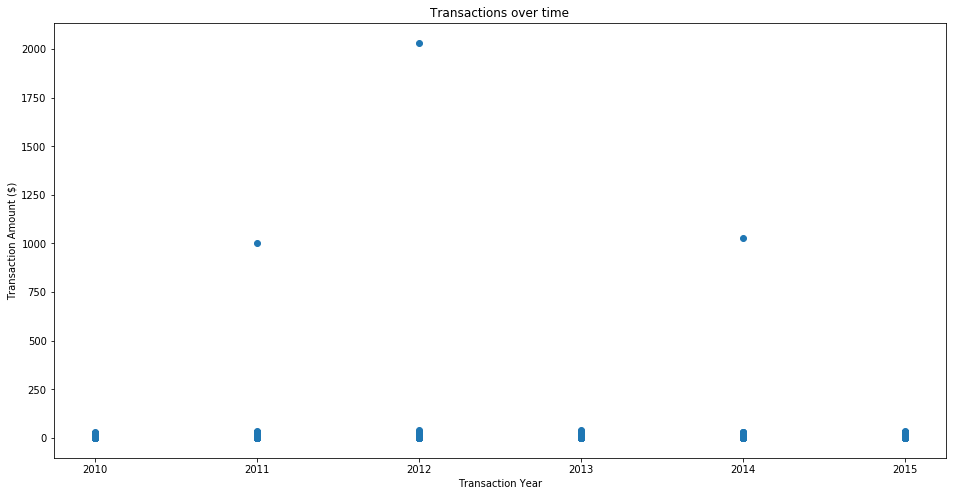

### Overall there  doesn't seem to be any relationship of amounts over time. Will explore this again after removing outliers


In [10]:
plt.figure(figsize=(16,8))
plt.scatter(x='Trx_Year', y='Amount', data=df)
plt.xlabel("Transaction Year")
plt.ylabel("Transaction Amount ($)")
plt.title("Transactions over time")
plt.show()
print("### Overall there  doesn't seem to be any relationship of amounts over time. Will explore this again after removing outliers")

In [11]:
df.groupby("Trx_Year")[["Amount"]].sum().reset_index() # Extracting year  

,Trx_Year,Amount
0,2010,2259.67
1,2011,4596.57
2,2012,7392.82
3,2013,6938.84
4,2014,8174.42
5,2015,8429.23


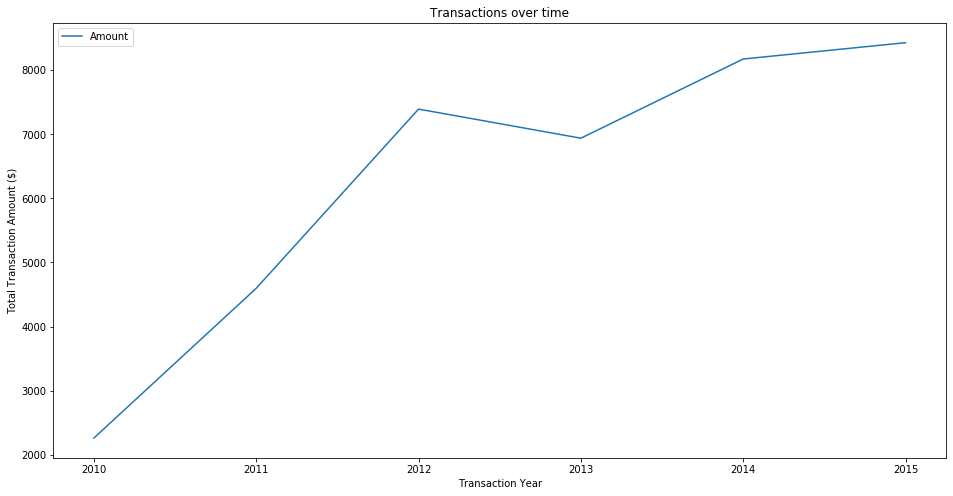

In [12]:
x = df.groupby("Trx_Year")[["Amount"]].sum()
x.plot(figsize=(16,8))
plt.xlabel("Transaction Year")
plt.ylabel("Total Transaction Amount ($)")
plt.title("Transactions over time")
plt.show()

Other that 2013, there has been a general increase in transaction amount over the years

## Step 2 - Further exploring the data

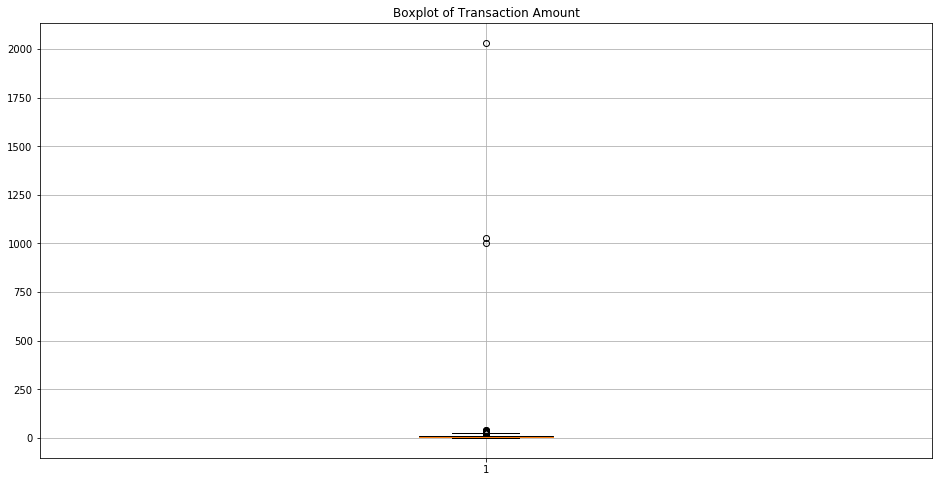

In [13]:
# 1. Are there any outliers? 
plt.figure(figsize=(16,8))
plt.boxplot(df['Amount'])
plt.grid()
plt.title("Boxplot of Transaction Amount")
plt.show()

Yes, there are a few outliers in the dataset

In [14]:
df.Amount.describe()

count    4186.000000
mean        9.028082
std        38.723909
min        -1.000000
25%         3.310000
50%         6.885000
75%        11.690000
max      2033.000000
Name: Amount, dtype: float64

Text(0.5, 1.0, 'Histogram of Transaction Amount')

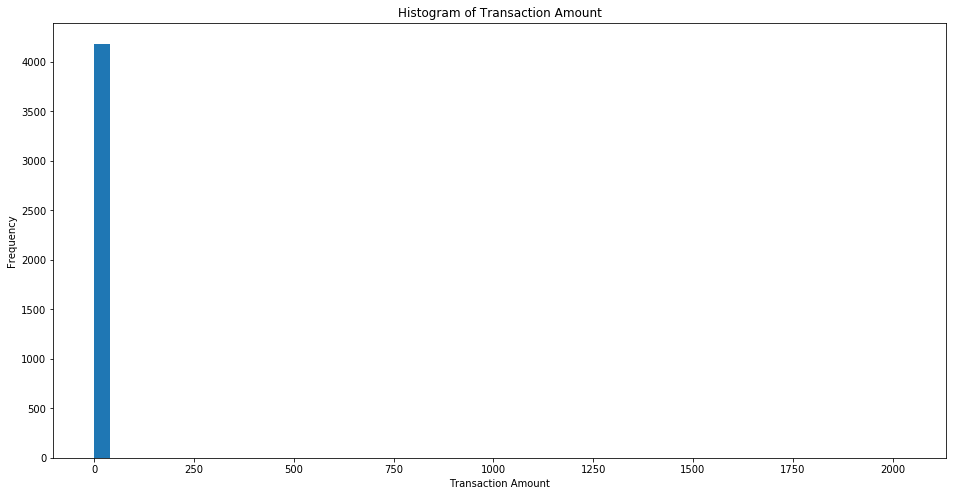

In [15]:
plt.figure(figsize=(16,8))
plt.hist(x='Amount', data=df, bins =50)
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.title("Histogram of Transaction Amount")

Becuase of the extremely low frequency of the outliers, they are not visible

Amounts that are 3 SDs away from the mean can be treated as outlier and negative values can be treated as anomalies. For the purpose of elimination, lets group them together as 'Outlier'

In [16]:
#Labeling the outliers and error

df['Outlier'] = np.logical_or(np.logical_or( (df['Amount'] <= (df['Amount'].mean() - (df['Amount'].std() * 3))), # 3SDs less
                              (df['Amount'] >= (df['Amount'].mean() + (df['Amount'].std() * 3)))  ), # 3SDs more
                              df['Amount']<0) # negative

#There are 5 outliers in the dataset
print("Transaction Outliers:")
df[df["Outlier"]==True]

Transaction Outliers:


,TransactionID,TransactionDate,CustomerID,Amount,Trx_Year,Outlier
23,24,10/7/2011,7,1003.0,2011,True
49,50,5/12/2012,13,-1.0,2012,True
211,212,5/14/2014,54,1027.0,2014,True
3326,3327,1/16/2014,811,-1.0,2014,True
4177,4178,8/13/2012,1000,2033.0,2012,True


In [17]:
# 2. If so how would you treat them?

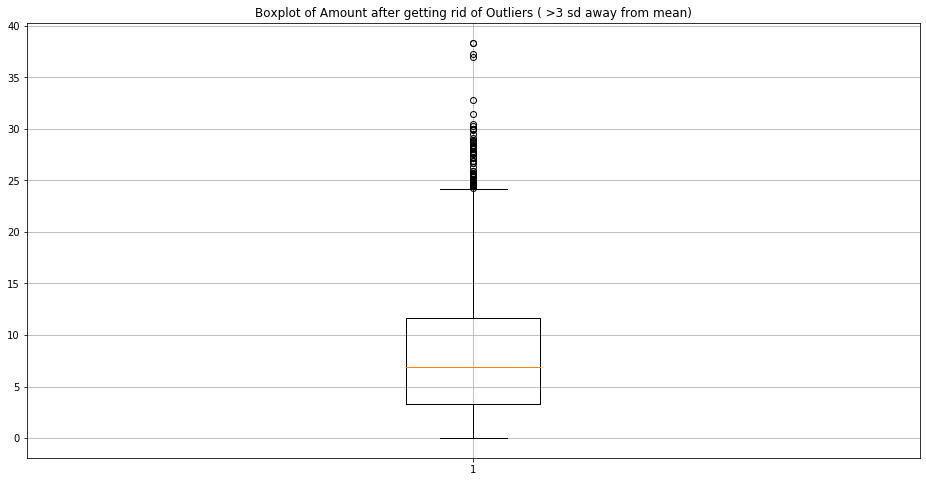

In [18]:
# We will filter out all the outliers
df = df[df['Outlier'] == False]

# New Boxplot
plt.figure(figsize=(16,8))
plt.title("Boxplot of Amount after getting rid of Outliers ( >3 sd away from mean)")
plt.boxplot(df['Amount'])
plt.grid()
plt.show()

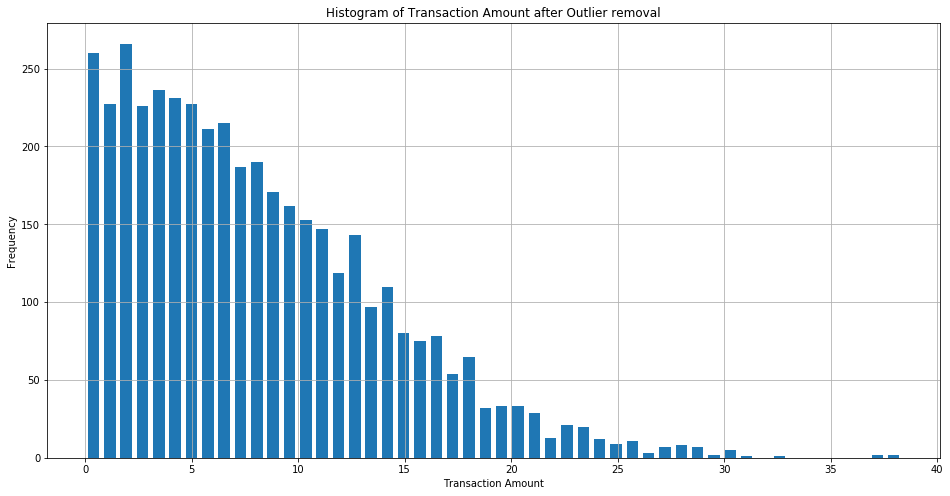

In [19]:
plt.figure(figsize=(16,8))
plt.hist(x='Amount', data=df, bins =50,rwidth=0.7)
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.title("Histogram of Transaction Amount after Outlier removal")
plt.grid()

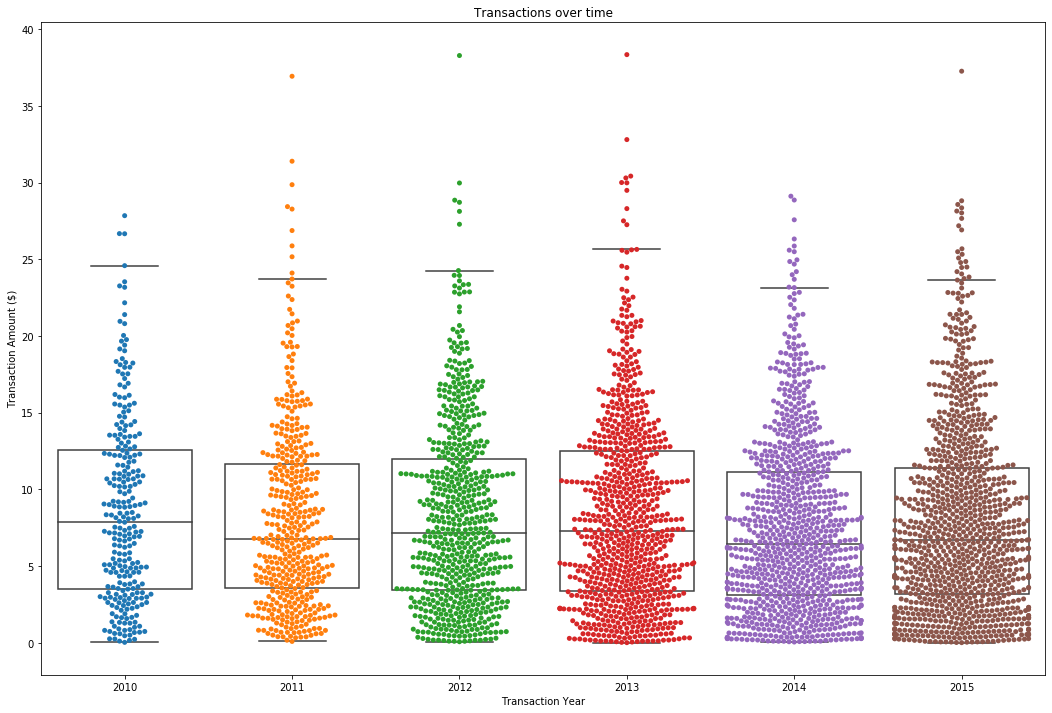

In [20]:
plt.figure(figsize=(18,12))
ax = sns.boxplot(x='Trx_Year', y='Amount', data=df,boxprops={'facecolor':'None'}, showfliers=False,whiskerprops={'linewidth':0})
ax = sns.swarmplot(x='Trx_Year', y='Amount', data=df)
plt.xlabel("Transaction Year")
plt.ylabel("Transaction Amount ($)")
plt.title("Transactions over time")
plt.show()

The mean transaction amounts appear to have stayed constant over the years but the counts have increased as seen in the above swarm plot

## Step 3 - Determining when the customers were first acquired

In [21]:
# Similar to a partition by function in SQL -- gets the minimum Trx_Year for each CustomerID
df["Origin Year"] = df.groupby('CustomerID').Trx_Year.transform(np.min) 

Displaying the origin year for a random customer

In [22]:
df.head(10)

,TransactionID,TransactionDate,CustomerID,Amount,Trx_Year,Outlier,Origin Year
0,1,9/4/2012,1,20.26,2012,False,2012
1,2,5/15/2012,2,10.87,2012,False,2012
2,3,5/23/2014,2,2.21,2014,False,2012
3,4,10/24/2014,2,10.48,2014,False,2012
4,5,10/13/2012,2,3.94,2012,False,2012
5,6,1/23/2013,2,12.37,2013,False,2012
6,7,3/9/2014,2,1.59,2014,False,2012
7,8,11/17/2013,2,2.75,2013,False,2012
8,9,10/10/2014,2,3.51,2014,False,2012
9,10,11/26/2012,3,21.58,2012,False,2012


#### Finding the Origin year for a random customer

In [23]:
df.loc[df["CustomerID"] == np.random.randint(100)]

,TransactionID,TransactionDate,CustomerID,Amount,Trx_Year,Outlier,Origin Year
308,309,5/31/2010,78,4.63,2010,False,2010
309,310,2/6/2014,78,11.55,2014,False,2010


## Step 4 - Calculating cumulative transaction amounts

In [24]:
df_cohort = df.groupby(['Origin Year', 'Trx_Year']) \
              .agg(Trx_amount=('Amount', 'sum')) \
              .reset_index(drop=False)
df_cohort["period_since_aquisition"]= (df_cohort["Trx_Year"]-df_cohort["Origin Year"]+1)*12
df_cohort["Cum_Trx_amount"] = df_cohort.groupby('Origin Year').Trx_amount.transform(np.cumsum)
cohort_table = df_cohort.pivot_table(index="Origin Year", columns="period_since_aquisition", values="Cum_Trx_amount").reset_index()
cohort_table["Origin Year"] = cohort_table["Origin Year"].apply(lambda x: str(x)+"-01-01 - " + str(x)+"-12-31", )
cohort_table.rename_axis("", axis=1).fillna("")

,Origin Year,12,24,36,48,60,72
0,2010-01-01 - 2010-12-31,2259.67,3614.78,5274.81,6632.37,7930.69,8964.49
1,2011-01-01 - 2011-12-31,2238.46,3757.9,5465.99,6703.11,7862.24,
2,2012-01-01 - 2012-12-31,2181.35,3874.69,5226.86,6501.85,,
3,2013-01-01 - 2013-12-31,2179.85,3609.81,5227.75,,,
4,2014-01-01 - 2014-12-31,1830.85,3262.05,,,,
5,2015-01-01 - 2015-12-31,1912.17,,,,,


## Step 5 - New Customers Cohort Analysis

In [25]:
a = df.groupby(['Origin Year', 'Trx_Year']) \
              .agg(Unique_customers=('CustomerID', 'nunique')) \
              .reset_index()
a["x"] = a["Unique_customers"] * np.floor(a["Origin Year"] / a["Trx_Year"]).astype("int")
a["x"] = a["x"].astype("int")
a["Unique_customers"] = a.groupby(['Origin Year']).x.transform(max)
del a["x"]
a["period_since_aquisition"]= (a["Trx_Year"]-a["Origin Year"]+1)*12
a = a.pivot_table(index="Origin Year", columns="period_since_aquisition", values="Unique_customers").reset_index()
a["Origin Year"] = a["Origin Year"].apply(lambda x: str(x)+"-01-01 - " + str(x)+"-12-31", )
a = a.rename_axis("", axis=1).fillna("")
a

,Origin Year,12,24,36,48,60,72
0,2010-01-01 - 2010-12-31,172.0,172,172,172,172,172
1,2011-01-01 - 2011-12-31,170.0,170,170,170,170,
2,2012-01-01 - 2012-12-31,163.0,163,163,163,,
3,2013-01-01 - 2013-12-31,180.0,180,180,,,
4,2014-01-01 - 2014-12-31,155.0,155,,,,
5,2015-01-01 - 2015-12-31,160.0,,,,,


## Step 6 - Historic CLV

In [26]:
clv_table = ((cohort_table.set_index("Origin Year"))/(a.set_index("Origin Year"))).fillna("")
clv_table

period_since_aquisition,12,24,36,48,60,72
Origin Year,,,,,,
2010-01-01 - 2010-12-31,13.137616,21.0162,30.6675,38.5603,46.1087,52.1191
2011-01-01 - 2011-12-31,13.167412,22.1053,32.1529,39.4301,46.2485,
2012-01-01 - 2012-12-31,13.382515,23.7711,32.0666,39.8887,,
2013-01-01 - 2013-12-31,12.110278,20.0545,29.0431,,,
2014-01-01 - 2014-12-31,11.811935,21.0455,,,,
2015-01-01 - 2015-12-31,11.951062,,,,,


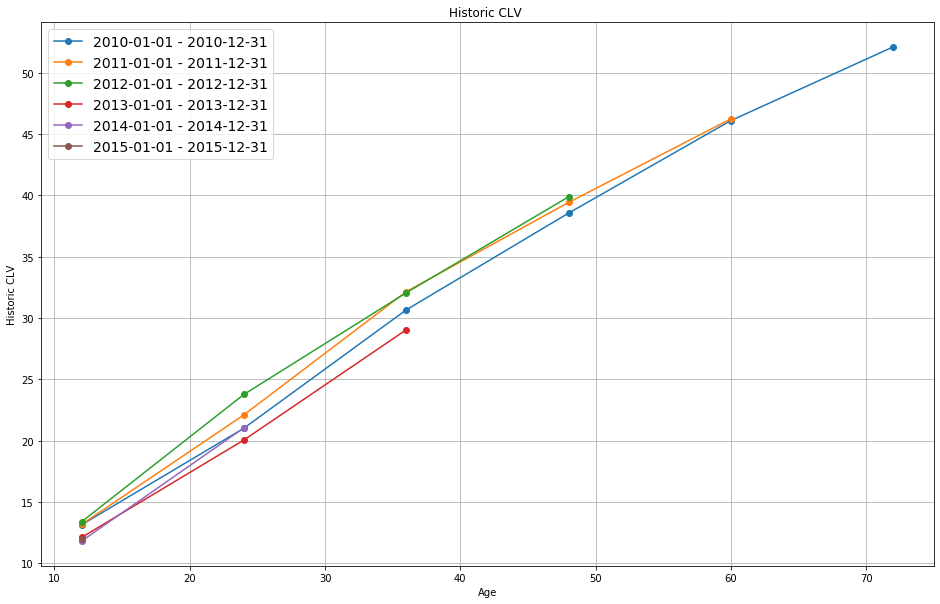

In [27]:
#Plotting historic CLV
plt.figure(figsize=(16,10))
cohort1, = plt.plot(clv_table.iloc[0], marker="o")
cohort2, = plt.plot(clv_table.iloc[1 ,0:5], marker= "o")
cohort3, = plt.plot(clv_table.iloc[2 ,0:4], marker= "o")
cohort4, = plt.plot(clv_table.iloc[3 ,0:3], marker= "o")
cohort5, = plt.plot(clv_table.iloc[4 ,0:2], marker= "o")
cohort6, = plt.plot(clv_table.iloc[5 ,0:1], marker= "o")

plt.title("Historic CLV ")
plt.xlabel('Age')
plt.ylabel('Historic CLV')

plt.grid()
plt.legend([cohort1, cohort2, cohort3, cohort4, cohort5, cohort6], clv_table.index,
           loc='upper left', prop={'size': 14})

plt.show()

## Step 7 - Interpretting Results

In [28]:
pd.DataFrame(clv_table.replace("", np.nan).mean(axis = 0, skipna = True).round(2), columns=["HistoricCLV"]).reset_index().rename(columns={"period_since_aquisition":"Age"})

,Age,HistoricCLV
0,12,12.59
1,24,21.60
2,36,30.98
3,48,39.29
4,60,46.18
5,72,52.12


- As we can see, customers aquired in 2011 have spent $ 7862.24
- Each cohort seems to exhibit similar spending pattern. The business implication is that customers will continue to give incremental and consitant business year-over-year and therefore efforts should be made to retain them. 
- Based on the Historic CLV, it can also be observed that older customers spend less money after 2 years than they did initially. This trend is worth noting and can be taking into consideration while planning markieting budgets for older customers.
- We also can notice that customers aquired in later years have been spending less on average in their first year. This could be due to the drop in product price but is again worth noting.   